### Overview
Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

### About the Dataset
This dataset was provided by Hadi Fanaee Tork using data from Capital Bikeshare, and is also graciously hosted by the UCI machine learning repository.

### Objective:
The objective of this exercise is to predict the total number of bike rentals (demand) using machine learning algorithms. We will also analyze how environmental factors such as temperature, wind, time, and weather affect rentals.

### This dataset contains the following attributes:
- datetime: hourly date + timestamp
- season: 1 = spring, 2 = summer, 3 = fall, 4 = winter
- holiday: whether the day is considered a holiday
- workingday: whether the day is a weekend or holiday
- weather:
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp: temperature in Celsius
- atemp: "feels like" temperature in Celsius
- humidity: relative humidity
- windspeed: wind speed
- casual: number of non-registered user rentals initiated
- registered: number of registered user rentals initiated
- count: number of total rentals (Dependent Variable)

In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
train = pd.read_csv("bike_train.csv")

### Quick Data Summary

In [3]:
train.shape

(10886, 12)

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
train.isnull().sum().sort_values(ascending = False)

count         0
registered    0
casual        0
windspeed     0
humidity      0
atemp         0
temp          0
weather       0
workingday    0
holiday       0
season        0
datetime      0
dtype: int64

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

Looking at the above results, the columns "season","holiday","workingday" and "weather" should be "categorical" data type, but are currently "int" datatypes. Before moving on, let's tranform the dataset to make it more manageable for data exploration.

### Transform the data
- Begin with the *datetime* column, creating new columns *date*, *hour*, *weekday*, *month* using Time Series.
- Change *season*, *holiday*, *workingday* and *weather* to category types.
- Drop the datetime column.

In [8]:
train['datetime'] = pd.to_datetime(train['datetime'],format='%Y-%m-%d %H:%M:%S')
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [9]:
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime']. dt.week

#### Convert category types

In [10]:
category_list = ["hour","dayofweek","month","season","weather","holiday","workingday"]
for var in category_list:
    train[var] = train[var].astype("category")

#### Drop unnecessary columns

In [11]:
train = train.drop(['datetime'], axis=1)

In [12]:
train.shape

(10886, 15)

In [13]:
train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,0,52
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,52
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,2,52


### Are there any missing values?

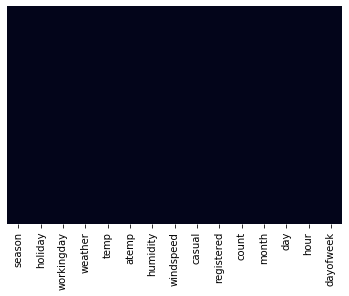

In [14]:
sns.heatmap(train.isnull(),yticklabels=False, cbar=False)

### Outlier Analysis with Boxplots

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Count Across Working Day')]

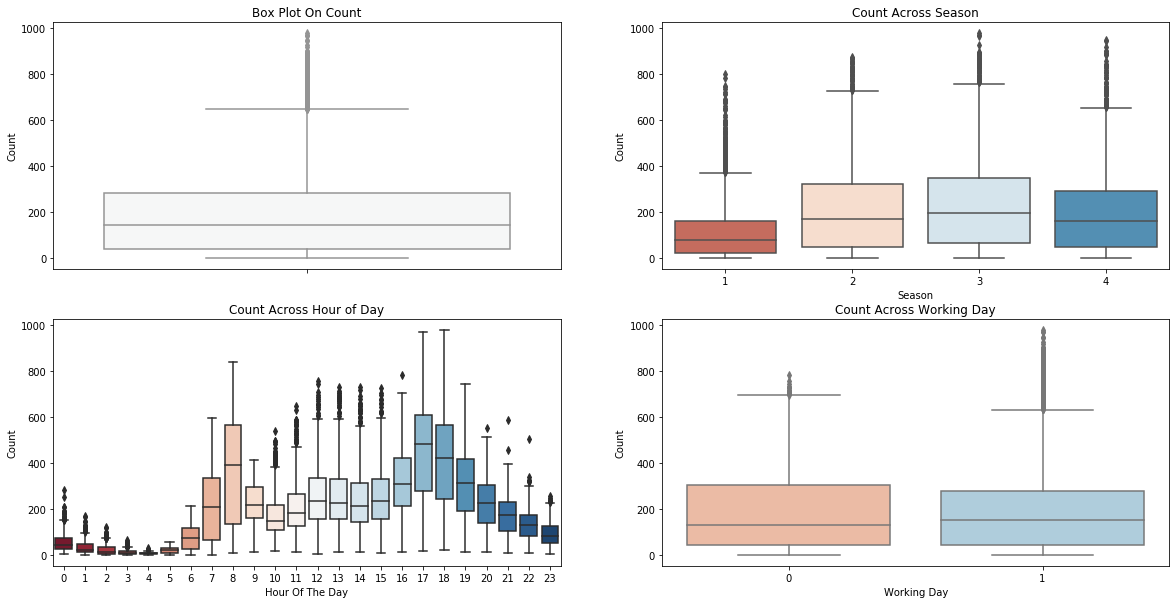

In [15]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 10)
sn.boxplot(y="count",data=train, orient="v",ax=axes[0][0], palette='RdBu')
sns.boxplot(x='season', y='count', data=train, ax=axes[0][1], palette='RdBu')
sn.boxplot(x="hour", y="count", data=train ,orient="v",ax=axes[1][0], palette='RdBu')
sns.boxplot(x='workingday', y='count', data=train,orient="v",ax=axes[1][1], palette='RdBu')

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Count Across Hour of Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Count Across Working Day")

#### Observations:
- Count column shows outliers
- Spring (1) has a noticeabe dip in median, with outliers
- 'Working Day' shows tmany outlier points

### Remove outliers in the count column

In [16]:
train_del_outliers = train[np.abs(train["count"] - train["count"].mean())<=(3*train["count"].std())]

In [17]:
print('Shape after removing outliers: ', (train_del_outliers.shape))

Shape after removing outliers:  (10739, 15)


### Observation:
- Highest number of bike rentals fell during peak commuting hours: 7-8am and 5-7pm
- lowest number of rentals were during twilight hours (12am -5am)
- On Saturday and Sunday, more people tend to rent bikes between 10AM and 4PM.
- The peak user count around 7AM-8AM and 5PM-6PM is purely contributed by registered user.**

### Bike rentals according to weather

/Users/kim-chido/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/kim-chido/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


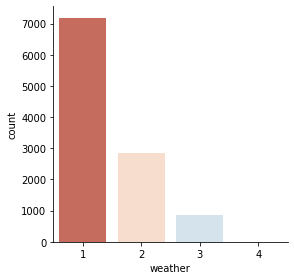

In [18]:
train.weather.value_counts()
sns.factorplot(x='weather',data=train,kind='count',size=4,aspect=1,palette= 'RdBu')
plt.show()

### Dependant Variables
How are rentals influenced by various features like temperature, atemp, humidity, and windspeed? A correlation matrix will help visualize.

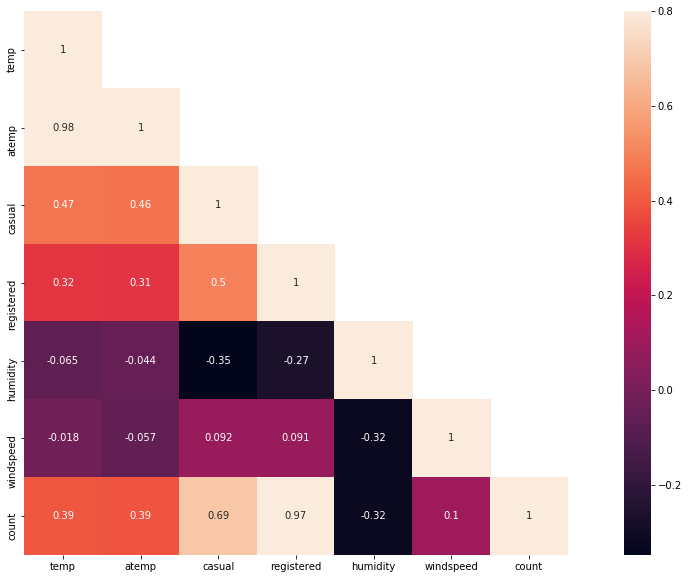

In [19]:
corr = train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corr, mask=mask,vmax=.8, square=True,annot=True)

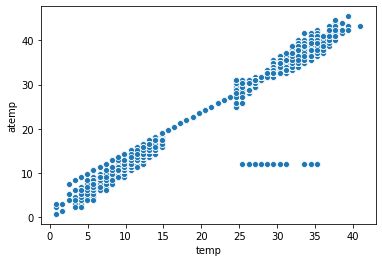

In [20]:
fig.set_size_inches(20,10)
sns.scatterplot(x="temp", y="atemp", data=train)

### Observations:
- windspeed is correlation value with "count"
- 'atemp' and 'temp' are highly correlated (multicolinearity)
- temp has positive correlation with count
- humidity has negative correlation with count. Although the correlation between them is not very prominent still the count variable has got little dependency on "temp" and "humidity".

### Decision:
- drop windspeed during model building
- Drop atemp to avoid multicolinearity.
- drop 'Casual' and 'Registered' during model building.

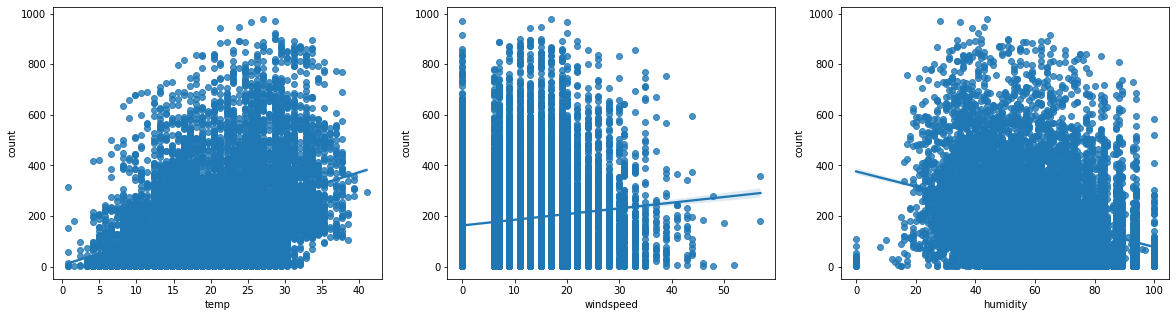

In [21]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(20, 5)
sn.regplot(x="temp", y="count", data=train,ax=ax1)
sn.regplot(x="windspeed", y="count", data=train,ax=ax2)
sn.regplot(x="humidity", y="count", data=train,ax=ax3)

### Distribution of Data
With outlier data removed, take log transformation of the count variable.

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909612))

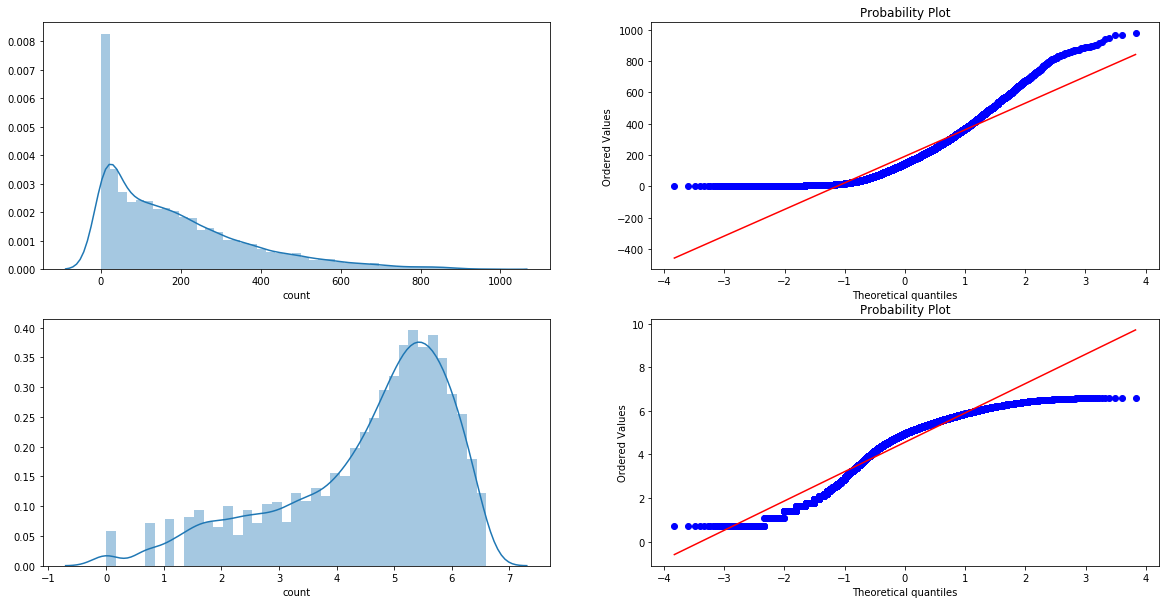

In [22]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20, 10)
sn.distplot(train["count"],ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(train_del_outliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(train_del_outliers["count"]), dist='norm', fit=True, plot=axes[1][1])

#### Observations: doesn't follow normal distribution. 

In [23]:
fig.set_size_inches(20,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(train.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

[Text(17.200000000000003, 0.5, 'Avearage Count'),
 Text(0.5, 17.200000000000003, 'Month'),
 Text(0.5, 1, 'Average Count By Month')]

## Modeling

In [24]:
train = pd.read_csv('bike_train.csv')
test = pd.read_csv('bike_test.csv')

In [25]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [26]:
# Append train and test
df = train.append(test)
df.reset_index(inplace = True)
df.drop('index', inplace=True, axis=1)

In [27]:
df.shape

(17379, 12)

In [28]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.6+ MB


In [29]:
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0


### Feature Engineering

In [30]:
df["date"] = df.datetime.apply(lambda x : x.split()[0])
df["hour"] = df.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
df["year"] = df.datetime.apply(lambda x : x.split()[0].split("-")[0])
df["weekday"] = df.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
df["month"] = df.date.apply(lambda dateStbring : datetime.strptime(dateString,"%Y-%m-%d").month)


In [31]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
 12  date        17379 non-null  object 
 13  hour        17379 non-null  int64  
 14  year        17379 non-null  object 
 15  weekday     17379 non-null  int64  
 16  month       17379 non-null  int64  
dtypes: float64(6), int64(8), object(3)
memory usage: 2.3+ MB


In [32]:
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,0,2011,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,1,2011,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2,2011,5,1


### Windspeed 
There are no longer missing values in the dataset, however there are a large number of zero values in the windspeed column. Use **random forests algorithm** to do a missing values analysis on windspeed.

Here is a visualiztion of the frequency of windspeed values in the data:

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Windspeed Values'),
 Text(0.5, 1.0, 'Count Of Windspeed Values'),
 None]

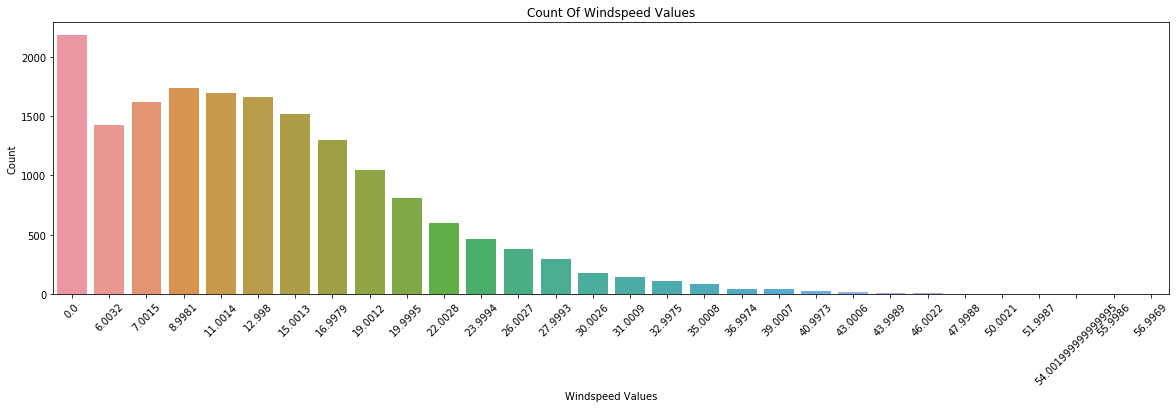

In [33]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
windspeed = pd.DataFrame(df.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sn.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='Windspeed Values', ylabel='Count',title="Count Of Windspeed Values",label='big')

### Fill in missing windspeed values using Random Forests Classifier
Consider the zeros as missing values, and use random forests classifier to fill them.

In [34]:
#random forests to predict zeros in windspeed
from sklearn.ensemble import RandomForestClassifier

windColumns = ["season","weather","humidity","month","temp","year","atemp"]
dataWind0 = df[df["windspeed"]==0]
dataWindNot0 = df[df["windspeed"]!=0]
dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

rfModel_wind = RandomForestClassifier()
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])

dataWind0["windspeed"] = wind0Values
df = dataWindNot0.append(dataWind0)
df["windspeed"] = df["windspeed"].astype("float")
df.reset_index(inplace=True)
df.drop('index',inplace=True,axis=1)

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Windspeed Values'),
 Text(0.5, 1.0, 'Count Of Windspeed Values After Imputation'),
 None]

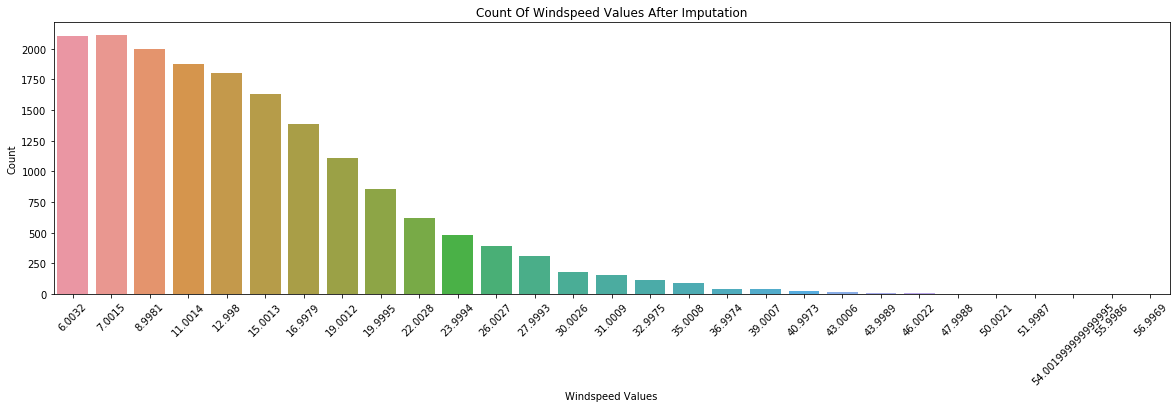

In [35]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
windspeed = pd.DataFrame(df.windspeed.value_counts()).reset_index()
plt.xticks(rotation=45) 
sn.barplot(data=windspeed,x="index",y="windspeed",ax=ax)
ax.set(xlabel='Windspeed Values', ylabel='Count',title="Count Of Windspeed Values After Imputation",label='big')

Now the 'missing' zero values have been imputed.

### Converting to categorical types

In [36]:
categoricalFeatures = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatures = ["temp","humidity","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [37]:
df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual        float64
registered    float64
count         float64
date           object
hour            int64
year           object
weekday         int64
month           int64
dtype: object

In [38]:
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0.0,1.0,1.0,2011-01-01,5,2011,5,1
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12.0,24.0,36.0,2011-01-01,10,2011,5,1
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26.0,30.0,56.0,2011-01-01,11,2011,5,1


In [39]:
# write a for loop to convert categorical features 
for var in categoricalFeatures:
    df[var] = df[var].astype("category")

In [40]:
df.shape

(17379, 17)

In [41]:
train.shape

(10886, 12)

### Train Test Split

In [42]:
train = df[pd.notnull(df['count'])].sort_values(by=["datetime"])
test = df[~pd.notnull(df['count'])].sort_values(by=["datetime"])
datetime = test["datetime"]
yLabels = train["count"]

In [43]:
train.dtypes

datetime        object
season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual         float64
registered     float64
count          float64
date            object
hour          category
year          category
weekday       category
month         category
dtype: object

In [44]:
#train validator split
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split( train, yLabels, test_size=0.3, random_state=42)
dateTimeValidate = X_validate["datetime"]

### Drop unnecessary Variables

In [45]:
train  = train.drop(dropFeatures,axis=1)
test  = test.drop(dropFeatures,axis=1)
X_train = X_train.drop(dropFeatures,axis=1)
X_validate = X_validate.drop(dropFeatures,axis=1)

In [46]:
def rmsle(y, y_,convertExp=True):

    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [48]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

# Initialize logistic regression model
m = LinearRegression()

# Train the model
m.fit(X = X_train,y = np.log1p(y_train))

# Make predictions
predictions = m.predict(X= X_validate)
print ("RMSLE Value For Linear Regression In Validation: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(predictions),False))

RMSLE Value For Linear Regression In Validation:  0.9829974526925036


In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfModel = RandomForestRegressor(n_estimators=100) ### Test 0.44
rfModel.fit(X = X_train,y = np.log1p(y_train))
predictions = rfModel.predict(X= X_validate)

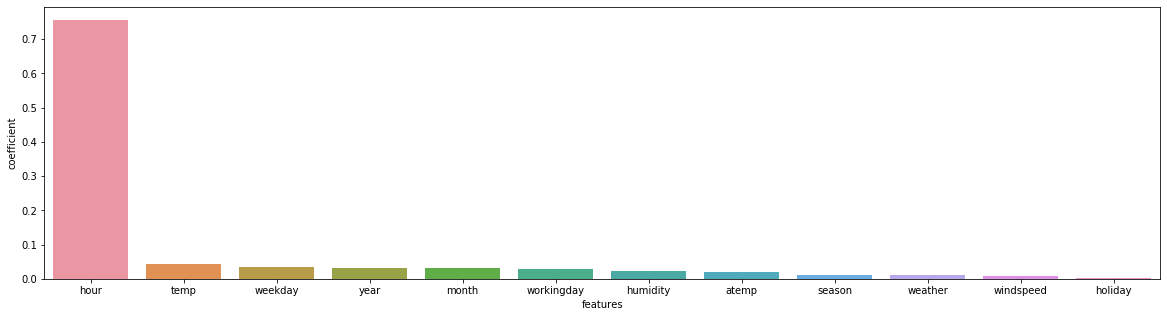

In [50]:
features = pd.DataFrame()
features['features'] = X_train.columns
features['coefficient'] = rfModel.feature_importances_
features.sort_values(by=['coefficient'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=features,x="features",y="coefficient",ax=ax)

In [ ]:
#inear regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
lModel.fit(X = X_train,y = np.log1p(y_train))

# Make predictions
preds = lModel.predict(X= X_validate)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor(max_depth=20)
#### Try tuning the Max Depth up and down to see what happens!


df = df.sort_values(by='hour')

X = train[['hour', ]]
y = train['count']

dtr.fit(X, y)
ypred = dtr.predict(X)
plt.figure(figsize=(12,8))
plt.scatter(X, y, s=1)
plt.plot(X, ypred)

In [ ]:
# seperate independent and target variable on train and test data
X_train = train.drop(columns=['count'],axis=1)
y_train = train['count']

X_test = test.drop(columns=['count'],axis=1)
y_test = test['count']

In [ ]:
train.head(3)

In [ ]:
train.shape, test.shape

In [ ]:
train.info()


In [ ]:
Xtrain.shape, Xtest.shape

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor(max_depth=20)
#### Try tuning the Max Depth up and down to see what happens!


df = df.sort_values(by='hour')

X = train
y = train['count']

dtr.fit(X, y)
ypred = dtr.predict(X)
plt.figure(figsize=(12,8))
plt.scatter(X, y, s=1)
plt.plot(X, ypred)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X, y)
ypred = lr.predict(X)

Using sklearn to first split to train, test, and then split train again into validation and train.

In [ ]:
train  = train.drop(dropFeatures,axis=1)
test  = test.drop(dropFeatures,axis=1)
X_train = X_train.drop(dropFeatures,axis=1)
X_validate = X_validate.drop(dropFeatures,axis=1)

## RMSLE Scorer
This will be the main metric we will focus on evaluating. It will be particularly helpful in **penalizing underestimation** of the actual values

In [ ]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))


Now a custom RMSLE scorer has been constructed, and we can start building models.

## Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV

lin_m = LinearRegression()

lin_m.fit(X_train,y_train)

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize logistic regression model
lin_m = LinearRegression()

# Train the model
lin_m.fit(X = X_train,y = np.log1p(y_train))

# Make predictions
predictions = lin_m.predict(X= X_validate)
print ("RMSLE Value: ",rmsle(y_validate,np.exp(predictions)))

In [ ]:
predsTest = lin_m.predict(X=test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(yLabels,ax=ax1,bins=100)
sn.distplot(np.exp(predsTest),ax=ax2,bins=100)
ax1.set(title="Training Set Distribution")
ax2.set(title="Test Set Distribution")

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01,0.05,0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
grid_ridge_m.fit(X = X_train,y = np.log1p(y_train))
predictions = grid_ridge_m.predict(X= X_validate)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(predictions),False))

fig,ax= plt.subplots()
fig.set_size_inches(20,5)
df = pd.DataFrame(grid_ridge_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

### Regularization Model - Lasso

In [ ]:
from sklearn.linear_model import Lasso
lasso_m_ = Lasso()

alpha  = [0.001,0.005,0.01,0.3,0.1,0.3,0.5,0.7,1]
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit(X = X_train,y = np.log1p(y_train))
preds = grid_lasso_m.predict(X= X_validate)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(20,5)
df = pd.DataFrame(grid_lasso_m.grid_scores_)
df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfModel = RandomForestRegressor(n_estimators=100) ### Test 0.44
rfModel.fit(X = X_train,y = np.log1p(y_train))
pred = rfModel.predict(X= X_validate)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(pred),False))

### Feature Importance by Random Forest

In [ ]:
features = pd.DataFrame()
features['features'] = X_train.columns
features['coefficient'] = rfModel.feature_importances_
features.sort_values(by=['coefficient'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=features,x="features",y="coefficient",ax=ax)

### Ensemble Model - Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01) ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(X = X_train,y = np.log1p(y_train))
pred = gbm.predict(X= X_validate)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(np.log1p(y_validate)),np.exp(pred),False))

### Compare the distribution of train and test results.

In [ ]:
test_pred = gbm.predict(X=test)

In [ ]:
ig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(yLabels,ax=ax1,bins=100)
sn.distplot(np.exp(predsTest),ax=ax2,bins=100)
ax1.set(title="Training Set Distbution")
ax2.set(title="Test Set Distribution")

In [ ]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(test_pred)]
    })
submission.to_csv('bike_prediction_output.csv', index=False)